#  Unsupervised learning addition model with generator

Author: S. Menary [sbmenary@gmail.com]

Date: 11/4/2023  (last update: 15/4/2023)

Overview: Train a `sequence -> sequence` model where the input sequence is a text representation of a simple sum $\sum_{i=1}^N A_i$ for a configurable number $N$ of integers $A_i\in\mathbb{Z}$, and the output is a set of logits representing the probability of each token in the output sequence. Integers may have a configurable number of digits. At inference time, chains of text are generated auto-regressively until the terminate-sequence token is reached. The loss function is a sparse categorical entropy.

---

## 1. Set up program

###  Import

All imports go here at the top of the notebook

In [1]:
##=========================##
##   All imports go here   ##
##=========================##

##  Import entire python stdlib packages
import logging, os, sys

##  Import entire pypi packages
import tensorflow as tf

##  Add directory above this to system path to expose mathsformer package location
sys.path.append("/".join(os.getcwd().split("/")[:-1]))

##  Import individual modules/objects from local packages
from mathsformer import config, data, transformers, utils
from mathsformer import selfsupervised_learning_addition_model_backend as backend


## 1. Configure run

Set configuration variables for entire program

In [2]:
##==============================##
##   Set custom config values   ##
##==============================##

custom_config = {
    "global" : {
        "base_seed"        : -1,
        "working_dir"      : "SSL_addition_generator_notebook_[problem_tag]_[model_tag]_[date]",
        "problem_tag"      : "int1234_num1245",
        "model_tag"        : "shallow_deep",
        "log_lvl_iostream" : logging.INFO,
        "log_lvl_fstream"  : logging.DEBUG,
    },
    "data" : {
        "train_data" : {
            "int_lengths"      : [1, 2, 3, 4],
            "num_ints"         : [1, 2, 4, 5],
            "batch_size"       : 32,
            "num_batches"      : 2000,
            "gen_base_seed"    : 100,
            "gen_reproducible" : False, 
        },
        "val_data" : {
            "int_lengths"      : [1, 2, 3],
            "num_ints"         : [3],
            "batch_size"       : 32,
            "num_batches"      : 250,
            "gen_base_seed"    : 101,
            "gen_reproducible" : True,
        },
        "test_data" : {
            "int_lengths"      : [5],
            "num_ints"         : [3],
            "batch_size"       : 32,
            "num_batches"      : 1000,
            "gen_base_seed"    : 102,
            "gen_reproducible" : True,
        },
        "characters"              : ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-'],
        "mask_char"               : 'M',
        "seq_start_char"          : 'B',
        "seq_end_char"            : 'E',
        "negative_char"           : 'N',
        "dtype"                   : "int32",
    },
    "model" : {
        "load_pretrained_model" : None,
        "name"                  : "mathsformer_LLM",
        "dtype"                 : "float32",
        "dropout"               : 0.1,
        "learning_rate"         : 1e-4,
        "jit_compile"           : False,
        "positional_encoding" : {
            "num_freqs"         : 8,
            "min_period"        : 4,
            "max_period"        : 300,
            "learnable"         : True,
        },
        "ndim_embedding"        : 16,
        "comb_type"             : 'average',
        "pre_encoder"           : {
            "num_layers"        : -1,
            "ndim"              : 128,
            "skip_connect"      : True,
        },
        "pre_decoder" : {
            "num_layers"        : -1,
            "ndim"              : 128,
            "skip_connect"      : True,
        },
        "encoder" : {
            "num_blocks"        : 10,
            "num_heads"         : 8,
            "ndim"              : 16,
            "ndim_att_hidden"   : 16,
            "ndim_ff_hidden"    : 64,
            "skip_connect"      : True,
        },
        "decoder" : {
            "num_blocks"        : 10,
            "num_heads"         : 8,
            "ndim"              : 16,
            "ndim_att_hidden"   : 16,
            "ndim_ff_hidden"    : 64,
            "skip_connect"      : True,
        },
        "post_decoder" : {
            "num_layers"        : 5,
            "ndim"              : 128,
        },
    },
    "training" : {
        "train"          : True,
        "max_epochs"     : 100000,
        "log_after_epoch" : {
            "do"          : True,
            "log_lvl"     : logging.DEBUG,
        },
        "early_stopping" : {
            "do"                   : True,
            "patience"             : 6,
            "monitor"              : "masked_accuracy",
            "mode"                 : "max",
            "restore_best_weights" : True,
        },
        "model_checkpoint" : {
            "do"       : True,
            "filename" : "model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.h5",
        },
        "layer_weights_record" : {
            "do"               : True,
            "batch_frequency"  : 2000,
            "recursive"        : True,
        },
        "adaptive_learning_rate" : {
            "do"                 : True,
            "decay_factor"       : 0.3,
            "monitor"            : "loss",
            "mode"               : "min",
            "patience"           : 1,
            "log_lvl"            : logging.DEBUG,
        },
        "print_tables_during_training" : {
            "do"        : True,
            "num_print" : 10,
        },
    },
    "evaluate" : {
        "num_print"            : 20,
        "save_model"           : True,
        "plot_weights"         : False,
        "plot_training_curves" : True,
    },
}


In [3]:
##===================================##
##   Load and validate full config   ##
##===================================##

##  Create config object containing default values
cfg = config.Config(backend.DEFAULT_CONFIG)

##  Override with custom values
cfg.load_dict(custom_config)

##  Validate config
backend.validate_config(cfg)

##  Print success
print(utils.fancy_message(f"Config created"))

##  For convenience, split configs for different sections
cfg_global   = cfg["global"  ]
cfg_data     = cfg["data"    ]
cfg_model    = cfg["model"   ]
cfg_training = cfg["training"]
cfg_evaluate = cfg["evaluate"]


===   Config created   ===


##  2. Set up environment

- Create working directory
- Create logger
- Log package versions for reproducibility
- Log config values for reproducibility
- Set random seeds for reproducibility


In [4]:
##==============================##
##   Create working directory   ##
##==============================##

##  Report success
working_dir, logger, base_seed, np_seed, tf_seed = utils.initialise_program(
    "unsupervised_learning_addition_model_generator (notebook)", 
    working_dir       = cfg_global["working_dir"], 
    cfg               = cfg,
    base_seed         = cfg_global["base_seed"],
    log_lvl_iostream  = cfg_global["log_lvl_iostream"],
    log_lvl_fstream   = cfg_global["log_lvl_fstream" ],
)


===   Working directory created at SSL_addition_generator_notebook_int1234_num1245_shallow_deep_2023_04_21_v4   ===
   INFO initialise_logging: Begin logging on 2023-04-21 at 12:03:42
   INFO initialise_program: Program description: unsupervised_learning_addition_model_generator (notebook)
   INFO initialise_program: Working directory: SSL_addition_generator_notebook_int1234_num1245_shallow_deep_2023_04_21_v4
   INFO log_versions: ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO log_versions:                                              PACKAGE  |  VERSION
   INFO log_versions: ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO log_versions:                                               Python  |  3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:29) [Clang 14.0.6 ]
   INFO log_versions

   INFO log_versions:                                 platformdirs.version  |  2.6.0
   INFO log_versions:                                       prompt_toolkit  |  3.0.36
   INFO log_versions:                                               psutil  |  5.9.4
   INFO log_versions:                                           ptyprocess  |  0.7.0
   INFO log_versions:                                            pure_eval  |  0.2.2
   INFO log_versions:                                    pure_eval.version  |  0.2.2
   INFO log_versions:                                               pydevd  |  2.9.1
   INFO log_versions:                                             pygments  |  2.13.0
   INFO log_versions:                                            pyparsing  |  3.0.9
   INFO log_versions:                                                   re  |  2.2.1
   INFO log_versions:                                             requests  |  2.28.1
   INFO log_versions:                                 requests

   INFO initialise_program: Registered config value data > test_data > num_batches: 1000
   INFO initialise_program: Registered config value data > test_data > gen_base_seed: 102
   INFO initialise_program: Registered config value data > test_data > gen_reproducible: True
   INFO initialise_program: Registered config value data > characters: ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-']
   INFO initialise_program: Registered config value data > mask_char: M
   INFO initialise_program: Registered config value data > seq_start_char: B
   INFO initialise_program: Registered config value data > seq_end_char: E
   INFO initialise_program: Registered config value data > negative_char: N
   INFO initialise_program: Registered config value data > dtype: int32
   INFO initialise_program: Registered config value model > load_pretrained_model: None
   INFO initialise_program: Registered config value model > name: mathsformer_LLM
   INFO initialise_program: Regis

##  3. Create training data

###  Create tokeniser

Tokeniser object handles the transformation from strings to tensors and back again

In [5]:
##======================##
##   Create tokeniser   ##
##======================##

token_transform = data.TokenTransform.from_dictionary(cfg_data)
token_transform.summary(print_fn=logger.info)


   INFO summary: TokenTransform of dtype int32 with 16 characters: ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-']
   INFO summary: Special characters are seq_start_char (B), seq_end_char (E), mask_char (M)
   INFO summary: Tokeniser dictionary is {'M': 0, 'B': 1, 'E': 2, 'N': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '+': 14, '-': 15}
   INFO summary: Detokeniser dictionary is {0: 'M', 1: 'B', 2: 'E', 3: 'N', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '+', 15: '-'}


###  Create data generators for train/val/test sets

Data generators create tensor inputs/outputs for the model on-the-fly


In [6]:
##============================##
##   Create data generators   ##
##============================##

train_gen, train_gen_reproducible, val_gen, test_gen = backend.get_data_generators(cfg_data, token_transform)


   INFO get_data_generators: Training data generator created with the following config: Generator of [1, 2, 4, 5] integers of length [1, 2, 3, 4] in 2000 batches of size 32 (base_seed=100, reproducible=False)
   INFO get_data_generators: Output shapes for a test batch are ((32, 26), (32, 7)), (32, 7)
   INFO get_data_generators: Validation data generator created with the following config: Generator of [3] integers of length [1, 2, 3] in 250 batches of size 32 (base_seed=101, reproducible=True)
   INFO get_data_generators: Output shapes for a test batch are ((32, 15), (32, 6)), (32, 6)
   INFO get_data_generators: Test data generator created with the following config: Generator of [3] integers of length [5] in 1000 batches of size 32 (base_seed=102, reproducible=True)
   INFO get_data_generators: Output shapes for a test batch are ((32, 22), (32, 8)), (32, 8)


##  4.  Create model

Create the keras model object that handles sequence-sequence transformations from alread-tokenised data

In [7]:
##===================================================##
##   Load or create self-supervised learning model   ##
##===================================================##

##  Get filename for load model
fname = cfg_model.get("load_pretrained_model", None)

##  Load model if fname is not None, otherwise create from scratch
if fname is not None :
    logger.info   (f"Loading model from: {fname}")
    logger.warning("Loading a pretrained model will disregard model config!")
    model = backend.load_text_to_text_model(fname)
else :
    logger.info(f"Creating new text-to-text model")
    model = backend.create_text_to_text_model_from_config(cfg_model, token_transform)

##  Create hack to catch model summary
model_summary = []
model.summary(print_fn = lambda s : model_summary.append(s))

##  Print model summary
logger.info("Model created with summary:")
for s in model_summary : logger.info(s)


   INFO <module>: Creating new text-to-text model
   INFO <module>: Model created with summary:
   INFO <module>: Model: "mathsformer_LLM"
   INFO <module>: __________________________________________________________________________________________________
   INFO <module>:  Layer (type)                   Output Shape         Param #     Connected to                     
   INFO <module>: ==================================================================================================
   INFO <module>:  mathsformer_LLM_encoder_input_  [(None, None)]      0           []                               
   INFO <module>:  layer (InputLayer)                                                                               
   INFO <module>:                                                                                                   
   INFO <module>:  mathsformer_LLM_encoder_enumer  (1, None)           0           ['mathsformer_LLM_encoder_input_l
   INFO <module>:  ate (Enumerate)        

   INFO <module>:  mathsformer_LLM_decoder_block_  (None, None, 16)    19504       ['mathsformer_LLM_decoder_emb_and
   INFO <module>:  1 (DecoderBlock)                                                _pos[0][0]',                     
   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1
   INFO <module>:                                                                  0[0][0]']                        
   INFO <module>:                                                                                                   
   INFO <module>:  mathsformer_LLM_decoder_block_  (None, None, 16)    19504       ['mathsformer_LLM_decoder_block_1
   INFO <module>:  2 (DecoderBlock)                                                [0][0]',                         
   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1
   INFO <module>:                                               

In [8]:
##==============================================================##
##   Create transformer wrapper for model and token_transform   ##
##==============================================================##

transformer = transformers.Transformer_Text_to_Text(model, token_transform)


In [9]:
##=========================================##
##   Test transformer on data generators   ##
##=========================================##

backend.test_transformer(transformer, train_gen, val_gen, test_gen)


   INFO test_transformer: Running text --> text mathsformer inference on some training data:
   INFO print_predictions_table: -------------------------------------------------------------------
   INFO print_predictions_table:                   INPUT       TRUE       PRED    CORRECT   RESIDUAL
   INFO print_predictions_table: -------------------------------------------------------------------
   INFO print_predictions_table:    N8806-N9827+N7374+N3      N6356                             ?   
   INFO print_predictions_table:        N824-N47+112+138       N527                             ?   
   INFO print_predictions_table:                  N8+736        728       4--+                  ?   
   INFO print_predictions_table:  1697-N426-N168-N4+5051       7346                             ?   
   INFO print_predictions_table:                9920+754      10674                             ?   
   INFO print_predictions_table:             52+81+N4-N4        133                             ?  

##  5.  Train model

In [10]:
##===================================##
##   Create callbacks for training   ##
##===================================##

callbacks = backend.get_callbacks(cfg_training, working_dir, transformer=transformer, train_gen=train_gen_reproducible, val_gen=val_gen)


   INFO get_callbacks: Registered training callback: LoggerCallback with loglvl=10
   INFO get_callbacks: Registered training callback: EarlyStopping with monitor=masked_accuracy, mode=max, patience=6, restore_best_weights=True
   INFO get_callbacks: Registeried training callback: AdaptiveLearningRate with decay_factor=0.3, patience=1, monitor=loss, mode=min, log_lvl=10
   INFO get_callbacks: Registeried training callback: ModelCheckpoint with filepath=SSL_addition_generator_notebook_int1234_num1245_shallow_deep_2023_04_21_v4/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.h5
   INFO get_callbacks: Registered training callback: LayerWeightsRecord with batch_frequency=2000, recursive=True
   INFO get_callbacks: Registered training callback: LambdaCallback for test_transformer with num_print=10


In [11]:
##=================##
##   Train model   ##
##=================##

do_train = cfg_training.get("train", True)

if do_train :
    max_epochs = cfg_training["max_epochs"]
    logger.info(f"Begin model training with max_epochs={max_epochs}")
    model.fit(train_gen, 
              epochs          = max_epochs,
              validation_data = val_gen,
              callbacks       = callbacks
             )
else :
    logger.warning("Skipping model training following global config instructions")


   INFO <module>: Begin model training with max_epochs=100000
Epoch 1/100000


2023-04-21 12:03:47.468844: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2000/2000 [==============================] - 281s 133ms/step - loss: 1.8942 - masked_accuracy: 0.3525 - val_loss: 2.0349 - val_masked_accuracy: 0.3573
Epoch 2/100000
2000/2000 [==============================] - 286s 143ms/step - loss: 1.7663 - masked_accuracy: 0.3708 - val_loss: 1.9609 - val_masked_accuracy: 0.3610
Epoch 3/100000
2000/2000 [==============================] - 307s 153ms/step - loss: 1.7138 - masked_accuracy: 0.3844 - val_loss: 1.9417 - val_masked_accuracy: 0.3609
Epoch 4/100000
2000/2000 [==============================] - 277s 139ms/step - loss: 1.6676 - masked_accuracy: 0.4015 - val_loss: 1.9559 - val_masked_accuracy: 0.3568
Epoch 5/100000
2000/2000 [==============================] - 291s 146ms/step - loss: 1.6212 - masked_accuracy: 0.4154 - val_loss: 1.8635 - val_masked_accuracy: 0.3855
Epoch 6/100000
2000/2000 [==============================] - 304s 152ms/step - loss: 1.5447 - masked_accuracy: 0.4423 - val_loss: 1.7939 - val_masked_accuracy: 0.3939
Epoch 7/100000
2000

KeyboardInterrupt: 

In [12]:
##================##
##   Save model   ##
##================##

do_save = cfg_evaluate.get("save_model", True)

if do_save :
    save_fname = f"{working_dir}/final_model.h5"
    model.save(save_fname)
    logger.info(f"Model saved to file {save_fname}")
else :
    logger.warning("Not saving model because no training was done")


   INFO <module>: Model saved to file SSL_addition_generator_notebook_int1234_num1245_shallow_deep_2023_04_21_v4/final_model.h5


## 6.  Evaluate model

In [13]:
  
##  Find out how many datapoints to print predictions for 
num_print = cfg_evaluate.get("num_print", 20)

##  Print tables
backend.test_transformer(transformer, train_gen, val_gen, test_gen, num_print=num_print)


   INFO test_transformer: Running text --> text mathsformer inference on some training data:
   INFO print_predictions_table: --------------------------------------------------------------------
   INFO print_predictions_table:                    INPUT       TRUE       PRED    CORRECT   RESIDUAL
   INFO print_predictions_table: --------------------------------------------------------------------
   INFO print_predictions_table:  2201+N7426+N7432+N5-N86     N12576      N1000                 11576
   INFO print_predictions_table:                    N9766      N9766      N9766        X            0
   INFO print_predictions_table:          3317+42+N5+N817       2537       3044                   507
   INFO print_predictions_table:                    N2042      N2042      N2042        X            0
   INFO print_predictions_table:                    N2+31         29        N10                   -39
   INFO print_predictions_table:                  65+N595       N530       N300            

##  7. Additional visualisations

In [14]:
##=============================================##
##   Visualise layer weights during training   ##
##=============================================##

if cfg_evaluate["plot_weights"] :
    
    logger.info("Plotting weights")
    backend.plot_weights(callbacks, show=True, close=True, savefig=f"{working_dir}/layer_weights.pdf")
    

   INFO <module>: Plotting training curves


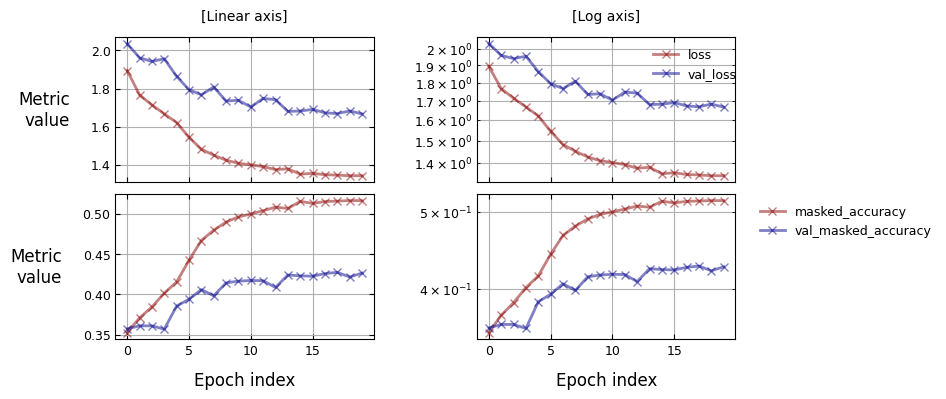

In [15]:

if cfg_evaluate["plot_training_curves"] :
    
    if not hasattr(model, "history") :
        logger.error("Cannot print training curves because no model history exists - perhaps you skipped training?")
    else :
        logger.info("Plotting training curves")
        backend.plot_training_curves(model.history.history, show=True, close=True, savefig=f"{working_dir}/training_curves.pdf")
    